<a href="https://colab.research.google.com/github/laxmimurali/Adversarial/blob/main/AdversarialNoiseToTargetClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Adversarial Noise

**Import standard libraries**

In [77]:
import os
import json
import math
import time
import numpy as np
import scipy.linalg
from PIL import Image
from fastai.vision.all import *
import shutil

# Visualization
import matplotlib.pyplot as plt

# Progress bar
from tqdm.notebook import tqdm

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim

# Torchvision
import torchvision.models as models
from torchvision import transforms
from torchvision import datasets
from torchvision.utils import make_grid
from torchvision.datasets.utils import download_url

**Fetching the device that will be used throughout this notebook.**




In [78]:
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


**Load the CNN pretrained on ImageNet**

In [79]:
resnet50 = models.resnet50(weights='IMAGENET1K_V1')
resnet50.eval()  # cuda preferable
for p in resnet50.parameters():
    p.requires_grad = False

resnet50.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

**User input**: Change the name of file to the user input filename

In [80]:
filename1 = '/content/dogphoto_GR.jpg'

**Default input**

In [81]:
dataset_url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
db = download_url(dataset_url,'.')
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])

Using downloaded and verified file: ./dog.jpg





1.   **Mean and Std from ImageNet**
2.   **Preprocess data**
3.  **Add batch dimensions**
4. **Convert to variable**



In [82]:
def process(filename):
  NORM_MEAN = np.array([0.485, 0.456, 0.406])
  NORM_STD = np.array([0.229, 0.224, 0.225])
  preprocess = transforms.Compose([transforms.Resize(256), # cuts out edges
                                 transforms.CenterCrop(224),  # then crop
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=NORM_MEAN,
                                                      std=NORM_STD)
                                 ])
  input_image = Image.open(filename)
  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0)
  input_batch = input_batch.to(device)
  input_variable = input_batch.clone().detach().requires_grad_(True)
  return(input_tensor, input_batch,input_variable)


In [83]:
input_tensor, input_batch,input_variable= process(filename=filename)

**Download ImageNet labels**


In [84]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2025-02-24 13:00:47--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt.3’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0.001s  

2025-02-24 13:00:47 (16.3 MB/s) - ‘imagenet_classes.txt.3’ saved [10472/10472]



**Classify the input using the resnet50 model and calculate the probability distribution over all the classes using softmax function**

In [85]:
def eval(img, model):
  with torch.no_grad():
      output = model(img)
      #print(output[0])
  probabilities = F.softmax(output[0], dim=0)
  #print(probabilities)
  # Read the categories
  with open("imagenet_classes.txt", "r") as f:
      categories = [s.strip() for s in f.readlines()]
  # Show top categories per image
  top5_prob, top5_catid = torch.topk(probabilities, 5)
  for i in range(top5_prob.size(0)):
      print(categories[top5_catid[i]], top5_prob[i].item())
  x_label = top5_catid[0]
  x_pred = categories[top5_catid[0]]
  x_pred_prob = top5_prob[0].item()
  return(x_label,x_pred, x_pred_prob)

In [86]:
x_label, x_pred, x_pred_prob = eval(input_batch, resnet50)

Samoyed 0.8732960820198059
Pomeranian 0.030270859599113464
white wolf 0.019671134650707245
keeshond 0.01107354462146759
Eskimo dog 0.009204240515828133


##Fast Gradient Sign Method (FGSM)

One of the first attack strategies proposed is Fast Gradient Sign Method (FGSM), developed by Ian Goodfellow et al. in 2014. Given an image, we create an adversarial example by the following expression:

$X^{adv} = X + ϵsign(\nabla_x J(X, Y_{true})$

$X$ : input
$X^{adv}$ : adversarial input
$ϵ$ : magnitude of adversarial perturbation
$\nabla_x J(X, Y_{true})$ : gradient of loss function wrt to input

Resembles SGD

Change input in the direction of maximising the loss



In [87]:
def I_FGSM_targeted(model, img, target_class, epsilon, alpha=0.01, num_iter=10):
    """
    Performs an iterative FGSM targeted attack.

    Parameters:
        model: The pre-trained classification model.
        img: The input image tensor [1, 3, H, W].
        target_class: The target class index for misclassification.
        epsilon: Total perturbation budget.
        alpha: Step size for each iteration.
        num_iter: Number of iterations.

    Returns:
        adv_img: The adversarial image.
        perturbation: The adversarial noise added.
    """

    img = img.clone().detach().to(device)  # Clone image
    adv_img = img.clone().detach().requires_grad_(True)  # Enable gradient tracking

    target = torch.tensor([target_class], dtype=torch.long, device=device)

    for _ in range(num_iter):
        output = model(adv_img)
        loss = F.cross_entropy(output, target)  # Minimize loss towards target
        model.zero_grad()
        loss.backward()

        # Compute gradient-based perturbation
        perturbation = alpha * adv_img.grad.sign()
        adv_img = adv_img - perturbation  # Move towards target class

        # Clip perturbation to be within epsilon-ball
        total_perturbation = torch.clamp(adv_img - img, -epsilon, epsilon)
        adv_img = torch.clamp(img + total_perturbation, 0, 1)

        adv_img = adv_img.detach().requires_grad_(True)  # Reset grad tracking

    # Final prediction
    output_adv = model(adv_img)
    pred_class = torch.argmax(output_adv, dim=1).item()

    return perturbation, adv_img, pred_class

# Example usage
epsilon = 0.3  # Total perturbation allowed
alpha = 0.05  # Step size per iteration
num_iter = 10  # More iterations = stronger attack
target_class = 285  # Egyptian Cat (ImageNet class)

perturbation, x_adv, x_adv_pred = I_FGSM_targeted(resnet50, input_variable, target_class, epsilon, alpha, num_iter)

print(f"Predicted class after attack: {x_adv_pred}")

Predicted class after attack: 285


**Visualization**

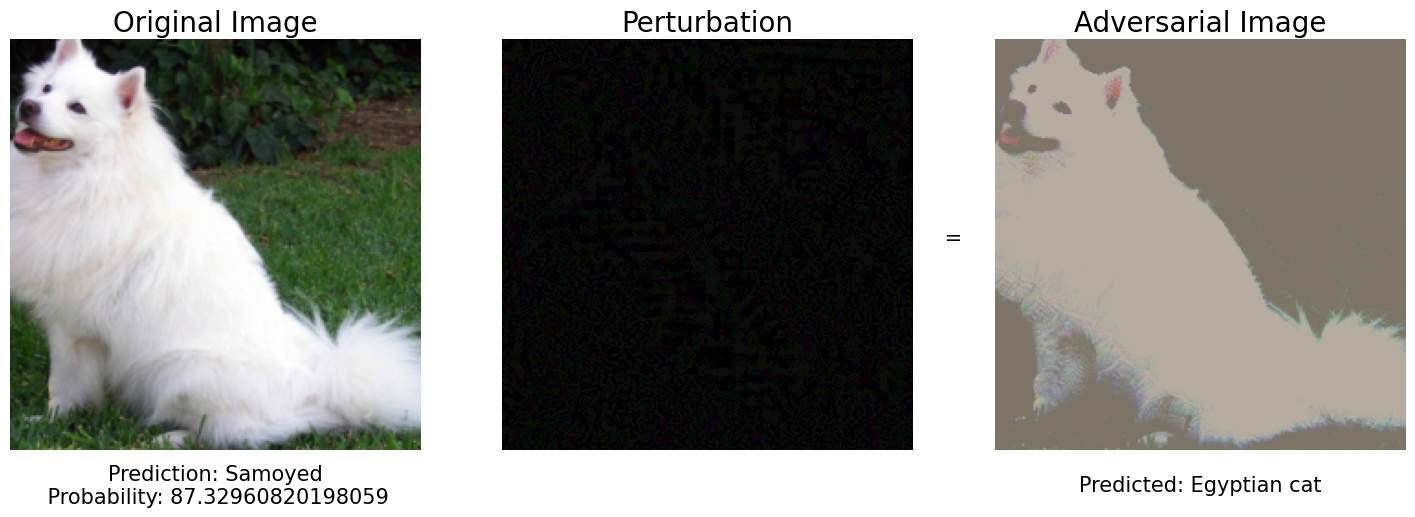

In [88]:
def visualize_targeted(x, x_adv, x_grad, epsilon, target_label, adv_pred, clean_pred, clean_prob):
    """
    Visualizes the original, perturbation, and adversarial images.

    Parameters:
        x: Original image tensor
        x_adv: Adversarial image tensor
        x_grad: Adversarial perturbation tensor
        epsilon: Perturbation strength
        target_label: The class the attack is targeting (tensor -> integer)
        adv_pred: The model's predicted class after attack (tensor -> integer)
    """

    # Unnormalize the images for visualization
    x = x.squeeze(0).to("cpu").detach()
    x = x.mul(torch.FloatTensor(NORM_STD).view(3,1,1)).add(torch.FloatTensor(NORM_MEAN).view(3,1,1)).detach().numpy()
    x = np.transpose(x, (1,2,0))
    x = np.clip(x, 0, 1)

    x_adv = x_adv.squeeze(0).to("cpu").detach()
    x_adv = x_adv.mul(torch.FloatTensor(NORM_STD).view(3,1,1)).add(torch.FloatTensor(NORM_MEAN).view(3,1,1)).detach().numpy()
    x_adv = np.transpose(x_adv, (1,2,0))
    x_adv = np.clip(x_adv, 0, 1)

    x_grad = x_grad.to("cpu").squeeze(0).detach().numpy()
    x_grad = np.transpose(x_grad, (1,2,0))
    x_grad = np.clip(x_grad, 0, 1)

    # Load class labels
    with open("imagenet_classes.txt", "r") as f:
        categories = [s.strip() for s in f.readlines()]

    # Plot images
    fig, ax = plt.subplots(1, 3, figsize=(18, 8))
    ax[0].imshow(x)
    ax[0].set_title('Original Image', fontsize=20)
    ax[0].axis('off')

    ax[1].imshow(x_grad)
    ax[1].set_title('Perturbation', fontsize=20)
    ax[1].axis('off')

    ax[2].imshow(x_adv)
    ax[2].set_title('Adversarial Image', fontsize=20)
    ax[2].axis('off')

    ax[0].text(0.5,-0.13, "Prediction: {}\n Probability: {}".format(clean_pred, clean_prob*100), size=15, ha="center",
         transform=ax[0].transAxes)
    ax[1].text(1.1,0.5, " = ", size=15, ha="center", transform=ax[1].transAxes)
    ax[2].text(0.5, -0.1, f"Predicted: {categories[adv_pred]}", size=15, ha="center", transform=ax[2].transAxes)

    plt.show()



visualize_targeted(input_tensor, x_adv, perturbation, epsilon, target_class, x_adv_pred, x_pred, x_pred_prob)
